In [4]:
from datasets import load_dataset
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import numpy as np

In [5]:
dad_jokes = pd.read_csv('../data/generated_data/dad_jokes_splitted_final.csv')
df = dad_jokes.copy()


In [6]:
import re
import pandas as pd

def normalize_for_dedup(text: str) -> str:
    """
    Aggressive normalization for comparison only:
    - lowercase
    - remove ALL non-word characters (punctuation, spaces, tabs, newlines, etc.)
    """
    if pd.isna(text):
        return ""
    t = str(text).lower()
    # keep only letters, digits and underscore; drop everything else
    t = re.sub(r"\W+", "", t, flags=re.UNICODE)
    return t


In [7]:
df["question"]    = df["question"].fillna("").astype(str)
df["response"] = df["response"].fillna("").astype(str)

df["question_norm"]    = df["question"].map(normalize_for_dedup)
df["response_norm"] = df["response"].map(normalize_for_dedup)

df["cluster_key"] = df["question_norm"] + " || " + df["response_norm"]


In [8]:
def keep_central_score_median(group: pd.DataFrame) -> pd.DataFrame:
    # median score of this cluster
    target = group["score"].median()
    # index of row closest to median
    idx = (group["score"] - target).abs().idxmin()
    return group.loc[[idx]]  # keep it as a DataFrame

df_dedup = (
    df
    .groupby("cluster_key", group_keys=False)
    .apply(keep_central_score_median)
    .reset_index(drop=True)
)

# drop helper columns
df_dedup = df_dedup.drop(columns=["question_norm", "response_norm", "cluster_key"])

print("Original:", len(df), "rows")
print("Deduped :", len(df_dedup), "rows")


Original: 57911 rows
Deduped : 54992 rows


/var/folders/2q/qf84z8xs67vfwjt96dblpb9c0000gn/T/ipykernel_6967/2077221295.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df


In [9]:
dad_jokes_dpo = df_dedup.copy()

In [10]:
dad_jokes_dpo = dad_jokes_dpo.rename(columns={
    "question": "setup",          
    "response": "punchline",   
})

dad_jokes_dpo["setup"] = dad_jokes_dpo["setup"].fillna("").str.strip()
dad_jokes_dpo["punchline"] = dad_jokes_dpo["punchline"].fillna("").str.strip()
dad_jokes_dpo = dad_jokes_dpo[(dad_jokes_dpo["setup"] != "") & (dad_jokes_dpo["punchline"] != "")]

In [11]:
def normalize_setup(text: str) -> str:
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

dad_jokes_dpo["setup_norm"] = dad_jokes_dpo["setup"].map(normalize_setup)


In [12]:
def best_vs_worst(group: pd.DataFrame):
    if len(group) < 2:
        return None

    hi = group.loc[group["score"].idxmax()]
    lo = group.loc[group["score"].idxmin()]

    # Skip if scores are identical
    if hi["score"] == lo["score"]:
        return None

    return pd.Series({
        "setup": hi["setup"],
        "chosen_punchline": hi["punchline"],
        "rejected_punchline": lo["punchline"],
        "chosen_score": hi["score"],
        "rejected_score": lo["score"],
    })




In [13]:
pairs_df = (
    dad_jokes_dpo.groupby("setup_norm", group_keys=False)
      .apply(best_vs_worst)
      .dropna()
      .reset_index(drop=True)
)

print("Number of preference pairs:", len(pairs_df))

Number of preference pairs: 783


/var/folders/2q/qf84z8xs67vfwjt96dblpb9c0000gn/T/ipykernel_6967/1989735524.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dad_jokes_dpo.groupby("setup_norm", group_keys=False)


In [14]:
pairs_df

,setup,chosen_punchline,rejected_punchline,chosen_score,rejected_score
0,A blind man walks into a bar,And a chair and a table,"He said ""ouch"", then walked into a club, and s...",22.0,5.0
1,A book just fell on my head.,I've only got myshelf to blame.,I only have my shelf to blame.,43.0,14.0
2,A guy walked into a bar,And was disqualified from the limbo contest.,Ouch!,3420.0,10.0
3,A Ham Sandwich Walks into a Bar,Strolls up to the bartender and says 'Pint of ...,and orders a beer. The bartender promptly says...,1053.0,10.0
4,A ham sandwich walks into a bar and orders a b...,"The bartender says, ""Sorry we don’t serve food...","The bartender says, ""I'm sorry, we don't serve...",98.0,12.0
...,...,...,...,...,...
778,You know what really makes my day?,the rotation of the earth,Earth's rotation.,24.0,8.0
779,You know what's really odd?,Numbers not divisible by two,Numbers which can't be divided by 2,3099.0,37.0
780,You know what?,"Dad: ""yes I do, great guy. Just saw him this m...",Not personally.,80.0,6.0
781,"You know, people say they pick their nose, but...",I just was born with mine.,I was just born with mine.,17.0,15.0


In [15]:
import re
import pandas as pd

def is_meta_only_setup(text: str) -> bool:
    """Return True if the whole setup is just TL;DR, NSFW label, link, etc."""
    if not isinstance(text, str):
        return True  # treat NaN as bad
    t = text.strip()
    if not t:
        return True

    # TL;DR only (variants: tl;dr, tl:dr:, etc.)
    if re.fullmatch(r'(?i)tl;?\s*dr:?', t):
        return True

    # NSFW labels only: "NSFW", "[NSFW]", "(nsfw)" etc.
    if re.fullmatch(r'(?i)[\[\(]*\s*nsfw\s*[\]\)]*', t):
        return True

    # bare http / https or www link
    if re.fullmatch(r'(https?://\S+|www\.\S+)', t, flags=re.IGNORECASE):
        return True

    # bare subreddit or similar: "r/funny"
    if re.fullmatch(r'(?i)r/\S+', t):
        return True

    return False


def apply_setup_filters(df: pd.DataFrame,
                        min_chars: int = 3,
                        max_chars: int = 512) -> pd.DataFrame:
    s = df["setup"].fillna("")

    # 1) meta-only setups
    mask_meta = s.apply(is_meta_only_setup)

    # 2) too long setups
    mask_long = s.str.len() > max_chars

    # 3) too short / only punctuation setups
    #    remove all non-alphanumeric characters and see what is left
    alnum = s.str.replace(r"[^0-9A-Za-z]+", "", regex=True)
    mask_short = alnum.str.len() < min_chars

    mask_drop = mask_meta | mask_long | mask_short

    print("Total rows:", len(df))
    print("  meta-only setups dropped :", mask_meta.sum())
    print("  too long setups dropped   :", mask_long.sum())
    print("  too short / punct. dropped:", mask_short.sum())
    print("  total dropped             :", mask_drop.sum())

    return df[~mask_drop].reset_index(drop=True)


In [16]:
pairs_df = apply_setup_filters(pairs_df, min_chars=3, max_chars=256)

Total rows: 783
  meta-only setups dropped : 0
  too long setups dropped   : 2
  too short / punct. dropped: 1
  total dropped             : 3


In [17]:
#pairs_df.to_csv("dad_jokes_dpo_pairs.csv", index=False)
pairs_df

,setup,chosen_punchline,rejected_punchline,chosen_score,rejected_score
0,A blind man walks into a bar,And a chair and a table,"He said ""ouch"", then walked into a club, and s...",22.0,5.0
1,A book just fell on my head.,I've only got myshelf to blame.,I only have my shelf to blame.,43.0,14.0
2,A guy walked into a bar,And was disqualified from the limbo contest.,Ouch!,3420.0,10.0
3,A Ham Sandwich Walks into a Bar,Strolls up to the bartender and says 'Pint of ...,and orders a beer. The bartender promptly says...,1053.0,10.0
4,A ham sandwich walks into a bar and orders a b...,"The bartender says, ""Sorry we don’t serve food...","The bartender says, ""I'm sorry, we don't serve...",98.0,12.0
...,...,...,...,...,...
775,You know what really makes my day?,the rotation of the earth,Earth's rotation.,24.0,8.0
776,You know what's really odd?,Numbers not divisible by two,Numbers which can't be divided by 2,3099.0,37.0
777,You know what?,"Dad: ""yes I do, great guy. Just saw him this m...",Not personally.,80.0,6.0
778,"You know, people say they pick their nose, but...",I just was born with mine.,I was just born with mine.,17.0,15.0


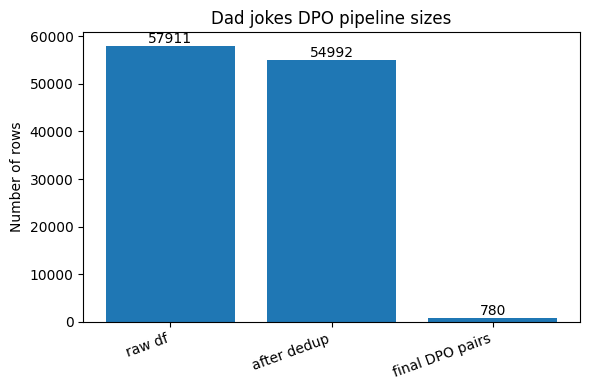

In [18]:
import matplotlib.pyplot as plt

stage_names = ["raw df", "after dedup", "final DPO pairs"]
counts = [len(df), len(df_dedup), len(pairs_df)]

plt.figure(figsize=(6, 4))
plt.bar(stage_names, counts)
plt.title("Dad jokes DPO pipeline sizes")
plt.ylabel("Number of rows")
plt.xticks(rotation=20, ha="right")

# annotate bars with exact values
for i, v in enumerate(counts):
    plt.text(i, v, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()
